# Problem definition

* Having data from the Polish side concerning car sales, I try to create such a model of machine learning that it is able to price the car on the basis of the information provided.

### Data dictionary
1.   Make - e.x BMW
2.   Seller - private person or company          
3.   YearOfProd - year of production of a car   
4.   Mileage (km) - Odometer  
5.   Color - color of a car      
6.   Fuel - type of fuel
7.   FuelCinCity - fuel consumption in city
8.   Gearbox - type of a gearbox in car      
9.   EngineVol (cm3)
10.  Horsepower
11.  Post-accident - 1(False)/ 0(True)
12.  Seats - number of seats in car      
13.  Doors - number of doors in a car
14.  Price - real price of car

# Imports

In [82]:
# Basic/ Manipulating data science packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump

# Sklearn models and packages
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# Models
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

# Functions

In [54]:
def score_model(y_true, y_preds):
    """
    Evaluates model effectiveness using given metrics:
    
    r^2 cooeficient
    MAE
    MSE
    Mean of cross validation score.
    
    sample:
        y_true = [1, 0, 1]
        y_preds = [1, 1, 1]
    
    Returns dictionary with calculated values. 
    """
    r2 = r2_score(y_true,
                  y_preds)
    mae = mean_absolute_error(y_true,
                              y_preds)
    mse = mean_squared_error(y_true,
                             y_preds)
    return {
        "R^2": round(r2, 2),
        "MAE": round(mae, 2),
        "MSE": round(mse, 2),
        "RMSE": np.sqrt(round(mse))
    }

def format_data(dataframe):
    """
    Converts string/ object data into categorical.
    Fill empty places with median in numeric data.
    If data is missing for some rows, creates new label at the end of the dataframe as
    binary representantion, if this value was missing.
    
    1 - True (value exist)
    0 - False (value wasn't provided)
    """
    # Fill empty places in numeric data
    for label, content in dataframe.items():
        if pd.api.types.is_numeric_dtype(content):
            if dataframe[label].isna().sum():
                # Adding ,,missing value" label
                dataframe[label + "_missing"] = pd.isnull(content)
                
                # Filling with media
                dataframe[label] = content.fillna(content.median())
                
    # Change string/ object data
    for label, content in dataframe.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Adding ,,missing value" label
            dataframe[label + "_missing"] = pd.isnull(content)
            
            # Converting categorical data into codes
            dataframe[label] = pd.Categorical(content).codes + 1
    
    return dataframe.reset_index(drop = True)
            
            

# Data exploration

In [55]:
# Loading data
car_prices_data = pd.read_csv("dane_stare.csv")
car_prices_data.head()

,Unnamed: 0,Make,Seller,YearOfProd,Mileage (km),Color,Fuel,FuelCinCity,Gearbox,EngineVol (cm3),Horsepower,Post-accident,Seats,Doors,Price
0,0,BMW,Private person,2005,284000.0,Gray,Petrol,12,Manual,2497.0,177.0,NaN,5.0,5.0,4853.27
1,1,Peugeot,Private person,2011,216800.0,Gray,Diesel,6,Manual,1997.0,140.0,0.0,5.0,5.0,7629.80
2,2,MINI,Private person,2014,99500.0,Brown,Diesel,6,Automatic,1995.0,143.0,0.0,5.0,5.0,14853.27
3,3,Opel,Private person,2017,95000.0,Red,Petrol,"7,70",NaN,1399.0,125.0,NaN,5.0,5.0,9864.56
4,4,Audi,Company,2019,98000.0,Black,Diesel,NaN,Automatic,1968.0,190.0,0.0,5.0,5.0,39480.81


In [56]:
# Checking data types
car_prices_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       2944 non-null   int64  
 1   Make             2944 non-null   object 
 2   Seller           2944 non-null   object 
 3   YearOfProd       2944 non-null   int64  
 4   Mileage (km)     2922 non-null   float64
 5   Color            2942 non-null   object 
 6   Fuel             2758 non-null   object 
 7   FuelCinCity      1663 non-null   object 
 8   Gearbox          1878 non-null   object 
 9   EngineVol (cm3)  2898 non-null   float64
 10  Horsepower       2467 non-null   float64
 11  Post-accident    1931 non-null   float64
 12  Seats            2763 non-null   float64
 13  Doors            2862 non-null   float64
 14  Price            2944 non-null   float64
dtypes: float64(7), int64(2), object(6)
memory usage: 345.1+ KB


In [57]:
# Searching empty places in dataframe
car_prices_data.isna().sum()

Unnamed: 0            0
Make                  0
Seller                0
YearOfProd            0
Mileage (km)         22
Color                 2
Fuel                186
FuelCinCity        1281
Gearbox            1066
EngineVol (cm3)      46
Horsepower          477
Post-accident      1013
Seats               181
Doors                82
Price                 0
dtype: int64

Text(0.5, 1.0, 'Histogram of prices in dataframe')

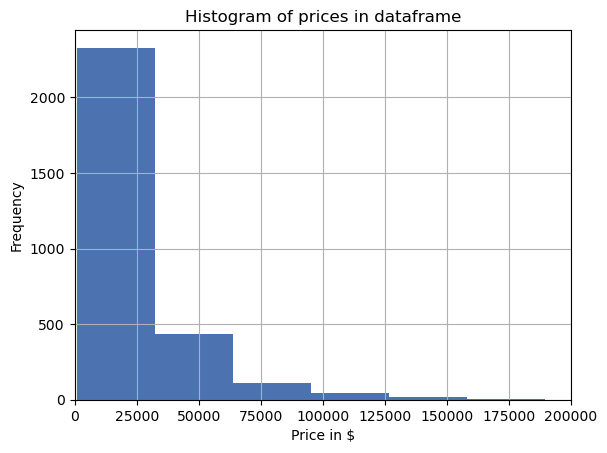

In [58]:
# Initializing new plot
fig, ax = plt.subplots()

ax = car_prices_data.Price.T.hist()

# x plot limitation
ax.set_xlim([0, 200_000]);

# Title of y, x axes
ax.set_ylabel("Frequency")
ax.set_xlabel("Price in $")

# Title of the plot
ax.set_title("Histogram of prices in dataframe")

Text(0.5, 1.0, 'Price dependence on engine volume (first 30 rows.)')

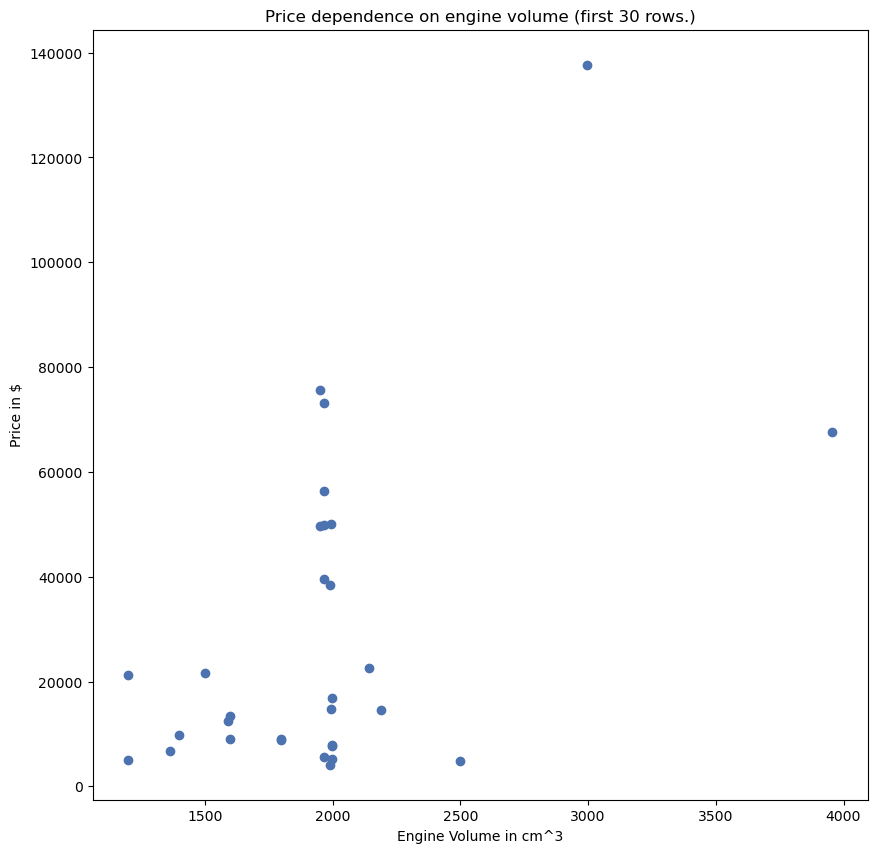

In [59]:
# Initializing new plot
fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(car_prices_data["EngineVol (cm3)"][:30],
           car_prices_data["Price"][:30]);

# Title of x, y axes
ax.set_xlabel("Engine Volume in cm^3")
ax.set_ylabel("Price in $")

# Title of the plot
ax.set_title("Price dependence on engine volume (first 30 rows.)")


In [60]:
# Formatting data
tmp_data = format_data(car_prices_data)
tmp_data.drop(tmp_data.filter(regex="Unname"),axis=1, inplace=True)

In [61]:
tmp_data.head()

,Make,Seller,YearOfProd,Mileage (km),Color,Fuel,FuelCinCity,Gearbox,EngineVol (cm3),Horsepower,...,Horsepower_missing,Post-accident_missing,Seats_missing,Doors_missing,Make_missing,Seller_missing,Color_missing,Fuel_missing,FuelCinCity_missing,Gearbox_missing
0,4,2,2005,284000.0,6,4,17,2,2497.0,177.0,...,False,True,False,False,False,False,False,False,False,False
1,39,2,2011,216800.0,6,1,67,2,1997.0,140.0,...,False,False,False,False,False,False,False,False,False,False
2,31,2,2014,99500.0,3,1,67,1,1995.0,143.0,...,False,False,False,False,False,False,False,False,False,False
3,38,2,2017,95000.0,8,4,84,0,1399.0,125.0,...,False,True,False,False,False,False,False,False,False,True
4,3,1,2019,98000.0,1,1,0,1,1968.0,190.0,...,False,False,False,False,False,False,False,False,True,False


In [62]:
tmp_data.isna().sum()

Make                       0
Seller                     0
YearOfProd                 0
Mileage (km)               0
Color                      0
Fuel                       0
FuelCinCity                0
Gearbox                    0
EngineVol (cm3)            0
Horsepower                 0
Post-accident              0
Seats                      0
Doors                      0
Price                      0
Mileage (km)_missing       0
EngineVol (cm3)_missing    0
Horsepower_missing         0
Post-accident_missing      0
Seats_missing              0
Doors_missing              0
Make_missing               0
Seller_missing             0
Color_missing              0
Fuel_missing               0
FuelCinCity_missing        0
Gearbox_missing            0
dtype: int64

In [63]:
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Make                     2944 non-null   int8   
 1   Seller                   2944 non-null   int8   
 2   YearOfProd               2944 non-null   int64  
 3   Mileage (km)             2944 non-null   float64
 4   Color                    2944 non-null   int8   
 5   Fuel                     2944 non-null   int8   
 6   FuelCinCity              2944 non-null   int8   
 7   Gearbox                  2944 non-null   int8   
 8   EngineVol (cm3)          2944 non-null   float64
 9   Horsepower               2944 non-null   float64
 10  Post-accident            2944 non-null   float64
 11  Seats                    2944 non-null   float64
 12  Doors                    2944 non-null   float64
 13  Price                    2944 non-null   float64
 14  Mileage (km)_missing    

# Modelling

In [64]:
# Creating test and valid data

x = tmp_data.drop("Price", axis = 1)
y = tmp_data.Price

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [65]:
x_train

,Make,Seller,YearOfProd,Mileage (km),Color,Fuel,FuelCinCity,Gearbox,EngineVol (cm3),Horsepower,...,Horsepower_missing,Post-accident_missing,Seats_missing,Doors_missing,Make_missing,Seller_missing,Color_missing,Fuel_missing,FuelCinCity_missing,Gearbox_missing
685,52,2,2014,160847.0,6,4,87,2,1390.0,122.0,...,False,False,False,False,False,False,False,False,False,False
2664,52,2,2020,47850.0,10,1,0,1,2967.0,286.0,...,False,False,False,False,False,False,False,False,True,False
2796,3,2,2002,223000.0,7,4,10,2,1984.0,130.0,...,False,False,False,False,False,False,False,False,False,False
456,19,1,2017,103000.0,1,1,0,2,1997.0,150.0,...,False,False,False,False,False,False,False,False,True,False
462,53,1,2021,22800.0,1,2,0,1,1968.0,408.0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,44,2,2006,248100.0,6,1,67,1,1968.0,140.0,...,False,False,False,False,False,False,False,False,False,False
1095,3,2,2002,236000.0,6,4,10,0,1781.0,163.0,...,False,True,False,False,False,False,False,False,False,True
1130,52,1,2023,1.0,6,4,0,1,1498.0,150.0,...,False,False,False,False,False,False,False,False,True,False
1294,4,2,2014,120000.0,6,4,94,0,1997.0,245.0,...,False,True,False,False,False,False,False,False,False,True


In [66]:
y_train

685      8532.73
2664    69954.85
2796     4040.63
456     19164.79
462     59568.40
          ...   
1638     3137.70
1095     2370.20
1130    44446.95
1294    16930.02
860      7426.64
Name: Price, Length: 2355, dtype: float64

In [67]:
model = RandomForestRegressor(random_state = 42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

# Evaluating 

In [68]:
model.score(x_test, y_test)

0.9380151290141107

In [69]:
cross_val_score(model, X = x, y = y, cv = 10).mean()

0.8699821032518431

In [70]:
y_preds = model.predict(x_test)

score_model(y_test, y_preds)

{'R^2': 0.94, 'MAE': 3601.44, 'MSE': 41459663.4, 'RMSE': 6438.917843861653}

In [71]:
difference = y_test - y_preds
result = pd.DataFrame({
    "Real value": y_test,
    "Predicted value": y_preds,
    "Difference": np.abs(round(difference, 2))
})
result

,Real value,Predicted value,Difference
565,31580.14,27869.7386,3710.40
1220,9706.55,10475.8491,769.30
1677,12392.78,13390.3819,997.60
1577,4173.81,5182.3921,1008.58
2831,112844.24,82540.0887,30304.15
...,...,...,...
772,1534.99,2147.3735,612.38
1255,34424.38,34024.0326,400.35
2574,6455.98,9913.2398,3457.26
2933,7426.64,8386.3818,959.74


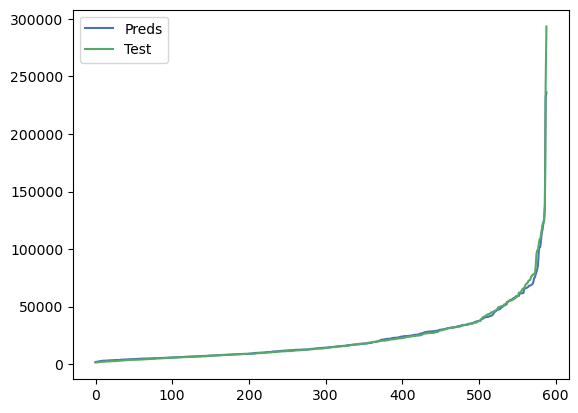

In [72]:
plt.plot(np.sort(y_preds))
plt.plot(np.sort(y_test))

plt.legend(["Preds", "Test"])

In [73]:
all_pred = np.sum(result["Difference"])
all_real = np.sum(result["Real value"])
all_pred/all_real

0.16350587851551734

# Hyperparameters tuning using RandomSearchCV / Unsuccessfull

In [74]:
search_grid = {
    "n_estimators": np.arange(0, 10000, 10),
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": np.arange(0, 1000, 5),
    "max_depth": np.arange(0, 100, 1)
}

reg_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1),
                               param_distributions = search_grid,
                               n_iter = 10,
                               cv = 5,
                               verbose = True)
reg_model.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 8...
       9240, 9250, 9260, 9270, 9280, 9290, 9300, 9310, 9320, 9330, 9340,
       9350, 9360, 9370, 9380, 9390, 9400, 9410, 9420, 9430, 9440, 9450,
       9460, 9470, 9480, 9490, 9500, 9510, 9520, 9530, 9540, 9550, 9560,
       9570, 9580, 9590, 9600, 9610, 9620, 9630, 9640, 9650, 9660, 9670,
       9680, 9690, 9700, 9710, 9720, 9730, 9740, 9750, 9760, 9770, 9780,
       9790, 9800, 9810, 9820, 9830, 9840, 9850, 9860, 9870, 9880, 9890,
       9900, 9910, 9920, 9930, 9940, 9950, 9960, 9970, 9980, 9990])},
                   verbose=True)

In [75]:
reg_model.best_params_

{'n_estimators': 9710,
 'min_samples_leaf': 140,
 'max_features': 'sqrt',
 'max_depth': 79}

In [76]:
y_preds = reg_model.predict(x_test)
score_model(y_test, y_preds)

{'R^2': 0.53, 'MAE': 8578.0, 'MSE': 313623469.62, 'RMSE': 17709.41755112234}

# Feature importances

In [77]:
model.feature_importances_

array([1.74448819e-02, 3.17136456e-03, 2.81254567e-01, 5.01474172e-02,
       8.63744205e-03, 6.33997121e-03, 5.97786162e-03, 2.28328915e-03,
       4.24896712e-02, 5.61816189e-01, 0.00000000e+00, 6.29584744e-03,
       4.27961606e-03, 4.48939698e-04, 7.09116142e-04, 5.54292974e-04,
       3.94127994e-03, 5.07452777e-04, 7.39225226e-04, 0.00000000e+00,
       0.00000000e+00, 5.51028047e-06, 1.13138424e-04, 1.98111315e-03,
       8.61813500e-04])

<AxesSubplot: >

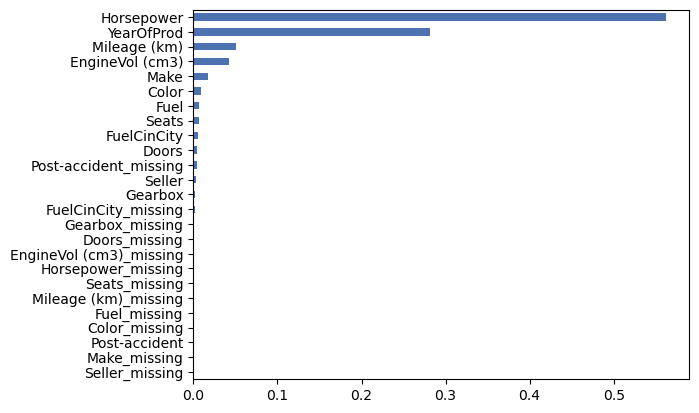

In [78]:
# Creating new series to plot
feauter_importances_series = pd.Series(model.feature_importances_, index = x_train.columns).sort_values()

# Changing style of matplotlib
plt.style.use('seaborn-v0_8-deep')

# Initializing and plotting
fig, ax = plt.subplots()
feauter_importances_series.plot.barh()

# Saving model

In [84]:
dump(model, open("Price_prediction_model.pkl", "wb"))